## data

### imports

In [ ]:
import os
import zipfile
import importlib
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive')
from modules import process_data, network_f, network_architectures
importlib.reload(network_architectures)

<module 'modules.network_architectures' from '/content/drive/MyDrive/modules/network_architectures.py'>

### get data

In [ ]:
data_path = '/content/drive/MyDrive/Thesis_Reading'

subjects = glob(data_path + '/*')

In [ ]:
# code to extract zips, ignore if already extracted

for subj in tqdm(subjects):
  zipf_path = glob(subj + '/*.zip')[0]
  dest_path = zipf_path[:-4]

  with zipfile.ZipFile(zipf_path, 'r') as zip_ref:
    zip_ref.extractall(dest_path)

In [ ]:
subj_data = {}


for subj in tqdm(subjects):
  fls = glob(subj + '/*')
  fls = os.listdir(subj)
  subj_id = 'subj_' + subj.split('/')[-1]

  for fl in fls:
    fl_path = f'{subj}/{fl}'
    if fl.endswith('.csv'):
      if fl.startswith('Data'):
        sensor_path = fl_path
      else:
        survey_path = fl_path
    elif os.path.isdir(fl_path):
      hr_path = fl_path

  sensor_data = pd.read_csv(sensor_path)
  channels = ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro']
  watch_data = np.stack([sensor_data[ch].values for ch in channels])
  watch_data = {'epoch': sensor_data['epoch'].values, 'values': watch_data}

  survey_data = pd.read_csv(survey_path)
  survey_data = {k:v for k,v in survey_data.items() if 'emo' not in k}
  
  hr_data = pd.read_csv(f'{hr_path}/HR.csv')
  hr_data = process_data.process_hr(hr_data, watch_data['epoch'][-1])

  subj_data[subj_id] = {'watch_data':watch_data, 'survey_data':survey_data, 'hr_data':hr_data}

  0%|          | 0/20 [00:00<?, ?it/s]

### plot watch data

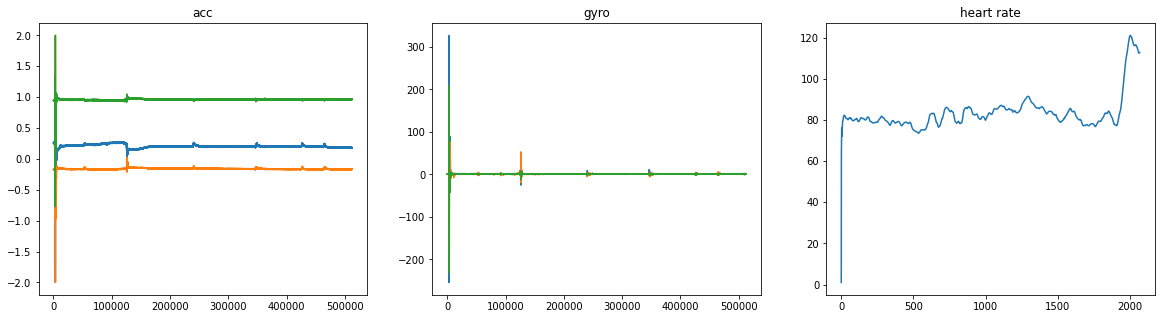

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(20,5))

plt.sca(axs[0])
# acc data
plt.plot(subj_data['subj_1']['watch_data']['values'][:3].T)
plt.title('acc')

plt.sca(axs[1])
# gyro data
plt.plot(subj_data['subj_1']['watch_data']['values'][3:].T)
plt.title('gyro')

plt.sca(axs[2])
plt.plot(subj_data['subj_1']['hr_data']['values'])
plt.title('heart rate')

plt.show()

### interpolate

In [ ]:
# interpolate watch data to be of same length

watch_data, hr_data = [], []
for subj_id in range(1,21):
  watch_data.append(subj_data[f'subj_{subj_id}']['watch_data']['values'])
  hr_data.append([subj_data[f'subj_{subj_id}']['hr_data']['values']])

watch_data = process_data.interpolate(watch_data, 50000, inputs_shape=(20,6,50000))
# watch_data, _ = process_data.standard_normal(watch_data, standardize=False)

hr_data = process_data.interpolate(hr_data, 2000, inputs_shape=(20,1,2000))
# hr_data, _ = process_data.standard_normal(hr_data, standardize=False)

resizing:   0%|          | 0/20 [00:00<?, ?it/s]

resizing:   0%|          | 0/20 [00:00<?, ?it/s]

### peak detection

In [ ]:
acc_max_idx = np.argmax( np.max(abs( subj_data['subj_1']['watch_data']['values'][:3]), 0) )
gyro_max_idx = np.argmax( np.max(abs( subj_data['subj_1']['watch_data']['values'][3:]), 0) )

sensor_max_idx = (acc_max_idx + gyro_max_idx) // 2
print(acc_max_idx, gyro_max_idx, sensor_max_idx)

hr_values = np.array(subj_data['subj_1']['hr_data']['values'])
hr_mean = hr_values.mean()
hr_devia = (hr_values - hr_mean)**2
hr_max_idx = np.argmax(hr_devia)
print(hr_max_idx)

3209 3202 3205
0


## neural network

Due to the difference in sampling rates, there are more data points of input (watch) corresponding to a single point of output (heart rate).

There are on average 500k input points and 2k output. The input has been interpolated to 50k and normalized between -1 and 1. The input has 6 channels (3 acc and 3 gyro).

Hence the input is of shape 20,6,50k <br>
where 20 is the number of subjects <br>
6 is the number of channels <br>
50k is the length of input after interpolation

### approach 1: fully connected network

Since there are 50k input points per 2k output, it gives 25 points per output.

And the input has 6 channels (3 acc and 3 gyro) it gives 25*6=150 points.

These are passed to a fully connected network as a regression problem (predicting heart rate). Mean squared error loss has been used.

Hence I have flattened the watch data and used it to predict a single output point of heart rate.

In [ ]:
print(watch_data.shape)
print(hr_data.shape)

(20, 6, 50000)
(20, 1, 2000)


In [ ]:
reshaped_watch_data = []
for wd in watch_data:
  x = []
  for i in range(2000):
    x.append(wd[:,i*25 : (i+1)*25].flatten())
  x = np.array(x)
  
  reshaped_watch_data.append(x)

reshaped_watch_data = np.array(reshaped_watch_data)

reshaped_watch_data.shape

(20, 2000, 150)

In [ ]:
reshaped_hr_data = hr_data.squeeze()
reshaped_hr_data.shape

(20, 2000)

In [ ]:
x = reshaped_watch_data.reshape(-1, 150)
print(x.shape)

x = reshaped_hr_data.reshape(-1,1)
print(x.shape)

(40000, 150)
(40000, 1)


In [ ]:
loaders = process_data.createLoaders(reshaped_watch_data.reshape(-1, 150), reshaped_hr_data.reshape(-1,1))

In [ ]:
model,criterion,optimizer = network_f.setupModel(network_architectures.Linear_Net())

params: 98521


training model


epoch:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 20  | train loss: 152.3684,  | avg train loss: 275.4358, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 40  | train loss: 123.8483,  | avg train loss: 136.8349, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 60  | train loss: 101.3545,  | avg train loss: 113.7611, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 80  | train loss: 83.1955,  | avg train loss: 90.7076, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 100  | train loss: 74.5534,  | avg train loss: 78.7772, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 120  | train loss: 64.4508,  | avg train loss: 69.9251, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 140  | train loss: 57.6490,  | avg train loss: 63.4751, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 160  | train loss: 53.1899,  | avg train loss: 57.2998, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 180  | train loss: 51.9681,  | avg train loss: 52.4780, 

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch: 200  | train loss: 46.7798,  | avg train loss: 48.5434, Finished Training


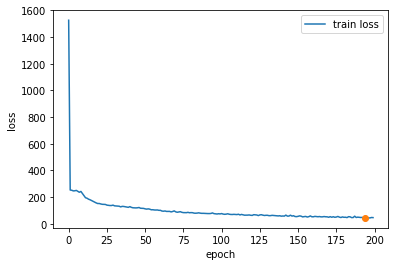

In [ ]:
best_params, last_params = network_f.train_model(model, criterion, optimizer, {'train': loaders['train']}, epochs=200)

In [ ]:
x = reshaped_watch_data[0]
y = reshaped_hr_data[0].reshape(-1,1)
print(x.shape)
print(y.shape)
test_loader = process_data.createLoader(x, y)

(2000, 150)
(2000, 1)


In [ ]:
y_pred = network_f.evaluate(model, test_loader)
y_pred = [i.numpy() for i in y_pred]

eval:   0%|          | 0/32 [00:00<?, ?it/s]

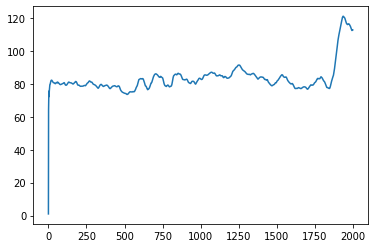

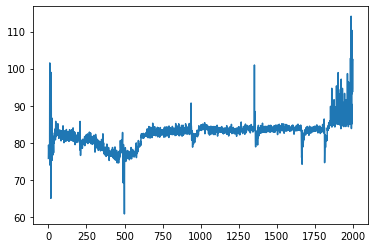

In [ ]:
plt.plot(y)
plt.show()
plt.plot(y_pred)

### approach 2:  convolution network

The entire input is passed through one dimensional convolutions and max pooling.

It reaches a shape of 250 channels of length 49, which is followed by average pooling to give 250,8.

This is then flattened to give 2000 points which are matched with the target to calculate the loss.

In [ ]:
print(watch_data.shape)
print(hr_data.shape)

(20, 6, 50000)
(20, 1, 2000)


In [ ]:
loaders = process_data.createLoaders(watch_data, np.squeeze(hr_data), batch_size=5)

In [ ]:
from torchsummary import summary

model = network_architectures.Conv_Net()
summary(model, (6, 50000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 64, 12499]           4,288
              ReLU-2            [-1, 64, 12499]               0
         MaxPool1d-3             [-1, 64, 4165]               0
            Conv1d-4            [-1, 192, 4165]          61,632
              ReLU-5            [-1, 192, 4165]               0
         MaxPool1d-6            [-1, 192, 1387]               0
            Conv1d-7            [-1, 384, 1387]         221,568
              ReLU-8            [-1, 384, 1387]               0
         MaxPool1d-9             [-1, 384, 461]               0
           Conv1d-10             [-1, 256, 461]         295,168
             ReLU-11             [-1, 256, 461]               0
        MaxPool1d-12             [-1, 256, 152]               0
           Conv1d-13             [-1, 250, 152]         192,250
             ReLU-14             [-1, 2

In [ ]:
model,criterion,optimizer = network_f.setupModel(network_architectures.Conv_Net())

params: 774906


training model


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 10  | train loss: 2349.7068,  | avg train loss: 3942.8425, 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 20  | train loss: 569.4286,  | avg train loss: 1148.1232, 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 30  | train loss: 286.7869,  | avg train loss: 393.5226, 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 40  | train loss: 219.9892,  | avg train loss: 233.6509, 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 50  | train loss: 167.8093,  | avg train loss: 201.5603, 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 60  | train loss: 119.6032,  | avg train loss: 133.6104, 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 70  | train loss: 135.8645,  | avg train loss: 108.2611, 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 80  | train loss: 109.4838,  | avg train loss: 128.3011, 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 90  | train loss: 111.3165,  | avg train loss: 98.3616, 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 100  | train loss: 88.5514,  | avg train loss: 90.1793, Finished Training


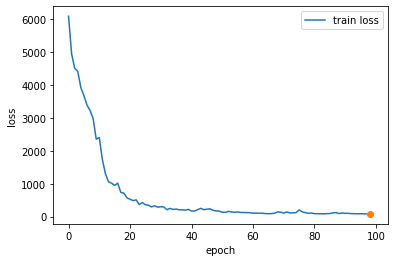

In [ ]:
best_params, last_params = network_f.train_model(model, criterion, optimizer, {'train': loaders['train']}, epochs=100)

In [ ]:
x = watch_data[:1]
y = reshaped_hr_data[:1]
print(x.shape)
print(y.shape)
test_loader = process_data.createLoader(x, y)

(1, 6, 50000)
(1, 2000)


In [ ]:
y_pred = network_f.evaluate(model, test_loader)
y_pred = [i.numpy() for i in y_pred]

eval:   0%|          | 0/1 [00:00<?, ?it/s]

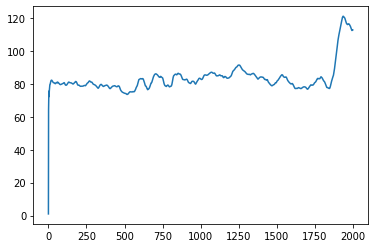

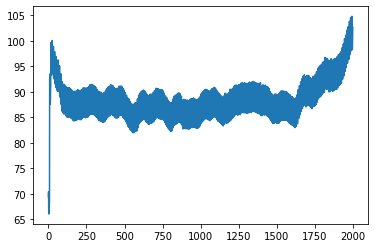

In [ ]:
plt.plot(y.T)
plt.show()
plt.plot(np.array(y_pred[0]).T)